In this brief tutorial, we show you how to train a pySCN classifier, assess its performance, and use it to predict the cell type of independent data.

### Data

#### Training data
We will use “10k PBMCs from a Healthy Donor (v3 chemistry) Single Cell Gene Expression Dataset by Cell Ranger 3.0.0” data set from 10X Genomics. You can [see how that data was analyzed and annotated](prepare_training_data). [link to processed training data](https://cnobjects.s3.amazonaws.com/singleCellNet/pySCN/resources/notebook_data/adPBMC_ref_040623.h5ad)

#### Query data
We will use another, unannotated Peripheral blood mononuclear cell (PBMC) data set here as the query data.

- [h5ad file of the query data](https://cnobjects.s3.amazonaws.com/singleCellNet/pySCN/resources/notebook_data/adPBMC_query_1_20k_HT_040723.h5ad)
- 20k Human PBMCs, 3’ HT v3.1, Chromium X
- Sourced from a healthy female donor
- 23,837 cells
- 35,000 reads per cell



In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import pySingleCellNet as cn

Load the data

In [3]:
adref = sc.read_h5ad("../../data/raw/pySCN_testdata/adPBMC_ref_040623.h5ad")
adref.shape

(10309, 20104)

In [4]:
adQuery = sc.read_h5ad("../../data/raw/pySCN_testdata/adPBMC_query_1_20k_HT_040723.h5ad")
adQuery.shape

(21677, 23836)

Limit data to same set of genes

In [5]:
cn.ut.limit_anndata_to_common_genes([adref, adQuery])
adref.shape

(10309, 19043)

The training step assumes that some basic processing has been performed on the training data.

In [6]:
sc.pp.highly_variable_genes(adref, n_top_genes=3000, flavor='seurat_v3')
sc.pp.normalize_total(adref)
sc.pp.log1p(adref)
adref.layers['lognorm'] = adref.X
sc.pp.pca(adref)

Split the training data into a training set and a held out validation set.

In [7]:
tids, vids = cn.ut.split_adata_indices(adref, groupby = "cell_type")
adTrain = adref[tids].copy()
adHO = adref[vids].copy()

In [8]:
adTrain.obs['cell_type'].value_counts()

cell_type
B cell             100
CD14 monocyte      100
CD4 T cell         100
CD8 T cell         100
Dendritic          100
FCGR3A monocyte    100
NK cell            100
Megakaryocyte       59
Name: count, dtype: int64

Train the classifier and apply it to the held out data. This process adds 'SCN_class_argmax' to adQuery.obs, and 'SCN_score' to adQuery.uns.

In [9]:
clf = cn.cl.train_classifier(adTrain, "cell_type", nRand = 100, n_comps = 10)
cn.cl.classify_anndata(adHO, clf)
adHO.obs['SCN_class_argmax'].value_counts()

Training classifier |████████████████████████████████████████| 5/5 [100%] in 4.1s (1.21/s) 


SCN_class_argmax
CD4 T cell         3272
CD14 monocyte      2874
B cell             1348
CD8 T cell         1088
NK cell             513
FCGR3A monocyte     339
Dendritic            95
rand                 19
Megakaryocyte         2
Name: count, dtype: int64

Assess the performance of the classifier in predicting labels of the held out data.

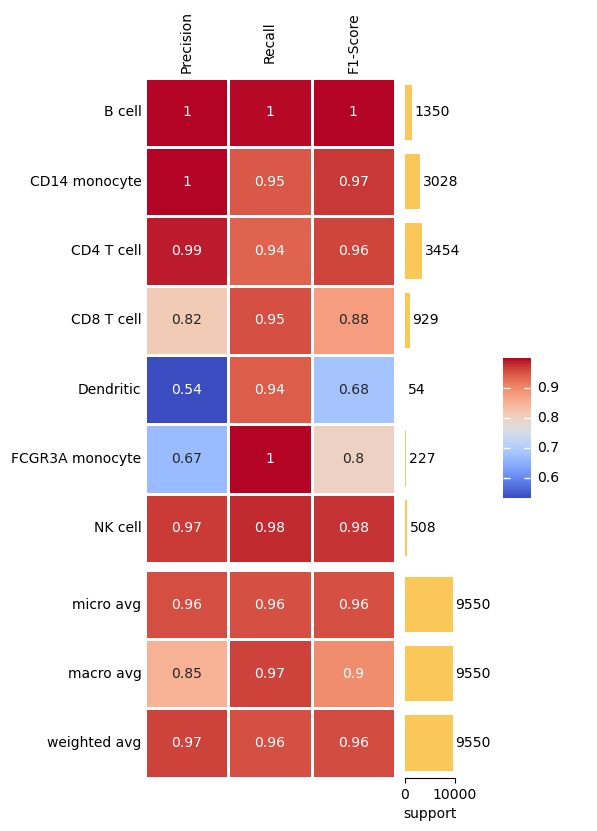

In [10]:
c_report = cn.cl.create_classifier_report(adHO, ground_truth='cell_type', prediction='SCN_class_argmax')
cn.pl.heatmap_classifier_report(c_report)
plt.show()

Now, we can apply thte classifier to the independent data.

In [11]:
cn.cl.classify_anndata(adQuery, clf)
adQuery.obs['SCN_class_argmax'].value_counts()

SCN_class_argmax
CD4 T cell         8160
CD14 monocyte      6548
B cell             2024
FCGR3A monocyte    1897
CD8 T cell         1778
NK cell             936
Dendritic           277
rand                 52
Megakaryocyte         5
Name: count, dtype: int64

Visualize the classification results as a heatmap

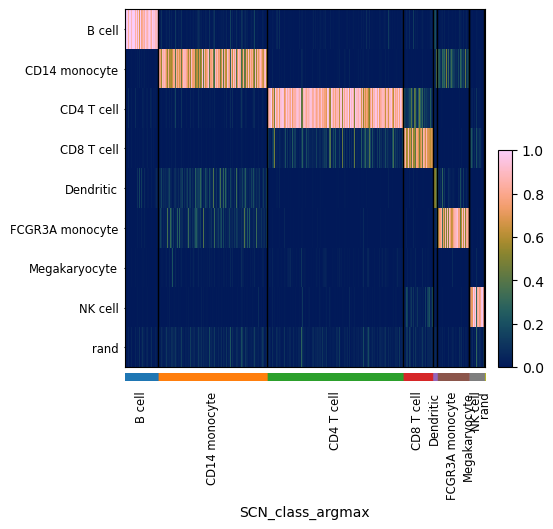

In [12]:
cn.pl.heatmap_scores(adQuery, groupby='SCN_class_argmax')

Compare the celltype proportions of the held out sample and the query sample. Only show those cell types that differ by more than 1% composition.

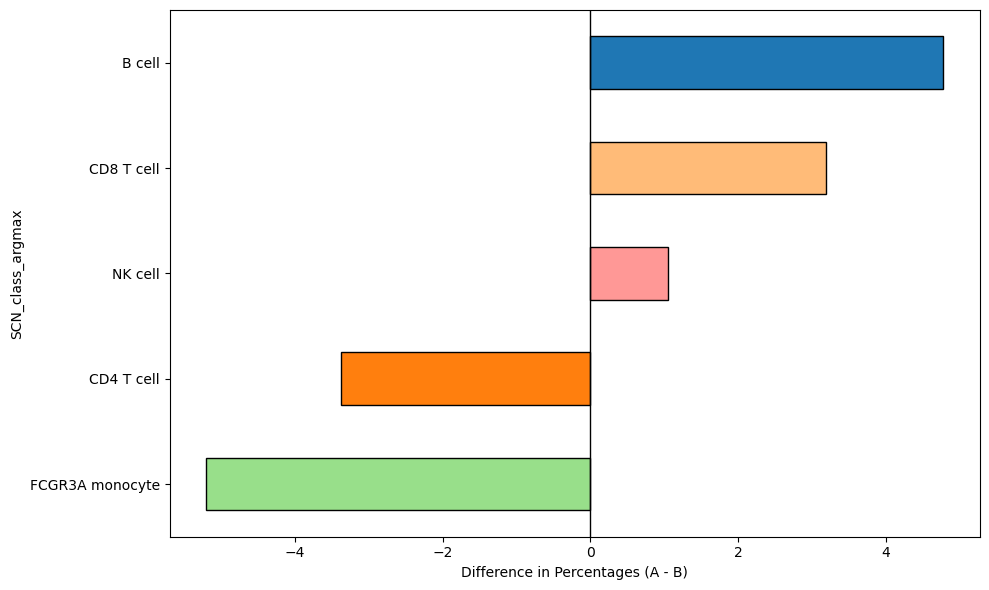

In [13]:
cn.pl.bar_compare_celltype_composition(adHO, adQuery, "SCN_class_argmax", min_delta = 1, colors = clf['ctColors'], metric='difference')

Visualize cell type composition with a stacked barplot.

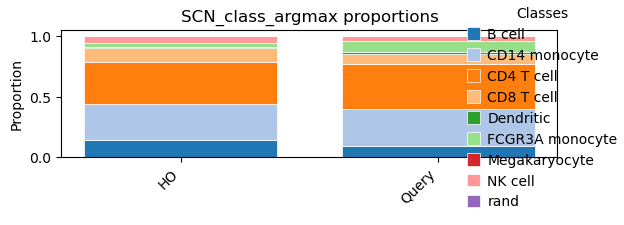

In [15]:
adlist = [adHO, adQuery]
adlabels = ["HO", "Query"]
afig = cn.pl.stackedbar_composition_list(adlist, labels=adlabels, color_dict=clf['ctColors'], obs_column = 'SCN_class_argmax')


#### Create embedding of query data
Sometimes it is informative to incorporate the SCN_scores into the embedding process as it emphasizes the cell type assignments. We achieve this by computing two kNN graphs. One is based on distances from PCs, the second is based on distances from the SCN_score matrix. Then, we run UMAP on the combination of these graphs.

In [16]:
sc.pp.highly_variable_genes(adQuery, n_top_genes=3000, flavor='seurat_v3')
sc.pp.normalize_total(adQuery)
sc.pp.log1p(adQuery)
adQuery.layers['lognorm'] = adQuery.X
sc.tl.pca(adQuery, mask_var='highly_variable')

In [17]:
def_npcs = 15
def_nneigh = 10
sc.pp.neighbors(adQuery, n_neighbors = def_nneigh,  n_pcs = def_npcs)
sc.pp.neighbors(adQuery, n_neighbors = def_nneigh,  use_rep = 'SCN_score', key_added='SCN_score_NN')
cn.ut.generate_joint_graph(adQuery, connectivity_keys = ["connectivities", "SCN_score_NN_connectivities"], weights=[0.5, 0.5], output_key='jointNN')
sc.tl.umap(adQuery, neighbors_key='jointNN')

We can compare the embeddings and clustering results using the joint embedding versus PC alone.
First, cluster based on the joint kNN graph, and plot the embedding.

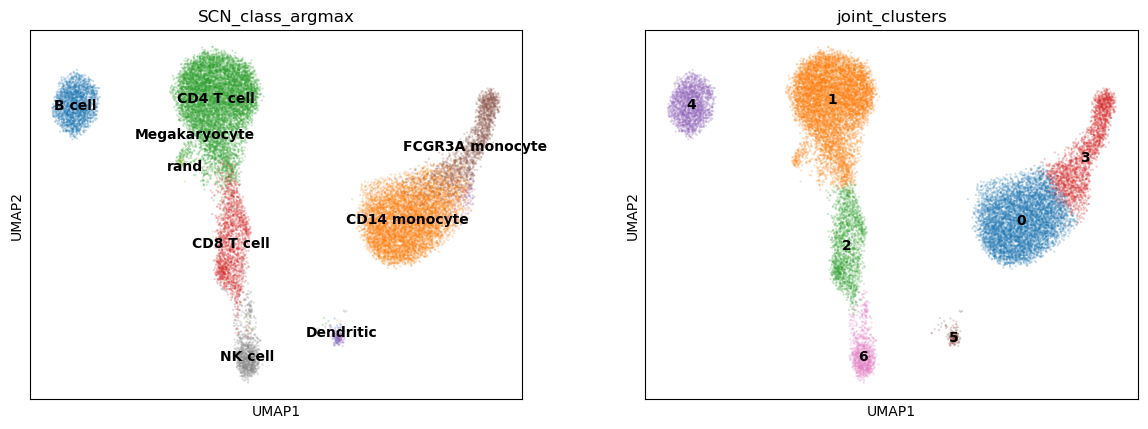

In [18]:
sc.tl.leiden(adQuery, adjacency=adQuery.obsp['jointNN_connectivities'], resolution=0.5, flavor="igraph", n_iterations=2, key_added="joint_clusters")
sc.pl.umap(adQuery, color=['SCN_class_argmax','joint_clusters'], size=10, alpha=.25, legend_loc='on data')

Now, cluster and run UMAP on the PC-only kNN.

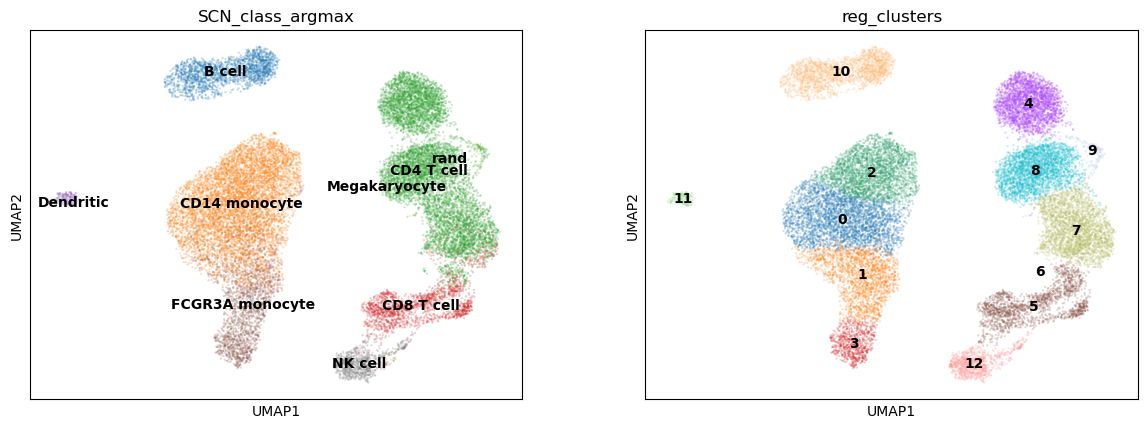

In [22]:
sc.tl.leiden(adQuery, adjacency=adQuery.obsp['connectivities'], resolution=0.5, flavor="igraph", n_iterations=2, key_added="reg_clusters")
sc.tl.umap(adQuery, neighbors_key='neighbors')
sc.pl.umap(adQuery, color=['SCN_class_argmax','reg_clusters'], size=10, alpha=.25, legend_loc='on data')